<a href="https://colab.research.google.com/github/ale-camer/Data-Science/blob/Finance/Named_Entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Named-entity recognition is a subtask of information extraction that seeks to locate and classify named entities mentioned in unstructured text into pre-defined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.

For this script I used the dataset of the Groningen Meaning Bank (GMB), which can be found [here](https://github.com/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2008%20-%20Project%206%20-%20Build%20your%20NER%20Tagger/ner_dataset.csv.gz), in order to resolve a classification problem with a labeled dataset.

## Packages, functions and data

In [ ]:
# packages
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore")

def sent2features(sent):

    def word2features(sent, i):
      word = sent[i][0]
      postag = sent[i][1]
      features = {
          'bias': 1.0,
          'word.lower()': word.lower(),
          'word[-3:]': word[-3:],
          'word[-2:]': word[-2:],
          'word.isupper()': word.isupper(),
          'word.istitle()': word.istitle(),
          'word.isdigit()': word.isdigit(),
          'postag': postag,
          'postag[:2]': postag[:2],
          }
      if i > 0:
          word1 = sent[i-1][0]
          postag1 = sent[i-1][1]
          features.update({
              '-1:word.lower()': word1.lower(),
              '-1:word.istitle()': word1.istitle(),
              '-1:word.isupper()': word1.isupper(),
              '-1:postag': postag1,
              '-1:postag[:2]': postag1[:2],
              })
      else:
          features['BOS'] = True
          if i < len(sent)-1:
              word1 = sent[i+1][0]
              postag1 = sent[i+1][1]
              features.update({
                  '+1:word.lower()': word1.lower(),
                  '+1:word.istitle()': word1.istitle(),
                  '+1:word.isupper()': word1.isupper(),
                  '+1:postag': postag1,
                  '+1:postag[:2]': postag1[:2],
                  })
          else:
              features['EOS'] = True
      return features

    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

df = pd.read_csv('/content/ner_dataset.csv.gz', compression='gzip',encoding='ISO-8859-1')
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
df.POS.unique(), df.Tag.unique()

(array(['NNS', 'IN', 'VBP', 'VBN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'CC',
        'JJ', '.', 'VBD', 'WP', '``', 'CD', 'PRP', 'VBZ', 'POS', 'VBG',
        'RB', ',', 'WRB', 'PRP$', 'MD', 'WDT', 'JJR', ':', 'JJS', 'WP$',
        'RP', 'PDT', 'NNPS', 'EX', 'RBS', 'LRB', 'RRB', '$', 'RBR', ';',
        'UH', 'FW'], dtype=object),
 array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
        'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
        'I-eve', 'I-nat'], dtype=object))

Part-Of-Speech (POS): https://cs.nyu.edu/~grishman/jet/guide/PennPOS.html

Tagging:



*   I (inside): prefix before a tag indicates that the tag is inside a chunk
*   B (beginning): prefix before a tag indicates that the tag is the beginning of a chunk 
*   O (outside): tag indicates that a token belongs to no chunk


*   geo: Geographical entity
*   org: Organization
*   per: Person
*   gpe: Geopolitical entity
*   tim: Time indicator
*   art: Artifact
*   eve: Event
*   nat: Natural phenomenon







## Preprocessing

In [ ]:
agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), s['POS'].values.tolist(), s['Tag'].values.tolist())]
df = df.groupby('Sentence #').apply(agg_func)
sentences = [s for s in df]
df[:3], sentences[:3]

(Sentence #
 Sentence: 1       [(Thousands, NNS, O)]
 Sentence: 10     [(Iranian, JJ, B-gpe)]
 Sentence: 100     [(Helicopter, NN, O)]
 dtype: object,
 [[('Thousands', 'NNS', 'O')],
  [('Iranian', 'JJ', 'B-gpe')],
  [('Helicopter', 'NN', 'O')]])

In [ ]:
X, y, encoder = np.array([sent2features(s) for s in sentences]), np.array([sent2labels(s) for s in sentences]), OrdinalEncoder()
print('Features: \n', X[:3], '\n\n', 'TAGs distribution: \n', pd.Series(y.ravel()).value_counts(normalize=True))

Features: 
 [[{'bias': 1.0, 'word.lower()': 'thousands', 'word[-3:]': 'nds', 'word[-2:]': 'ds', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'postag': 'NNS', 'postag[:2]': 'NN', 'BOS': True, 'EOS': True}]
 [{'bias': 1.0, 'word.lower()': 'iranian', 'word[-3:]': 'ian', 'word[-2:]': 'an', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'postag': 'JJ', 'postag[:2]': 'JJ', 'BOS': True, 'EOS': True}]
 [{'bias': 1.0, 'word.lower()': 'helicopter', 'word[-3:]': 'ter', 'word[-2:]': 'er', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'postag': 'NN', 'postag[:2]': 'NN', 'BOS': True, 'EOS': True}]] 

 TAGs distribution: 
 O        0.715403
B-per    0.083801
B-geo    0.069539
B-gpe    0.062324
B-org    0.057382
B-tim    0.010738
B-art    0.000375
B-nat    0.000229
B-eve    0.000209
dtype: float64


In [ ]:
# partitioning
y = np.concatenate(encoder.fit_transform(y))    

X_2 = []
for idx in tqdm(range(len(X))):
    X_2.append(list(X[idx][0].values()))
X_2 = pd.DataFrame(X_2,columns=list(X[0][0].keys()))
for col in X_2.columns:
    if X_2[col].dtype == 'O':
        X_2[col] = encoder.fit_transform(X_2[[col]])
    else:
        pass
for col in X_2.columns:
    if X_2[col].dtype == 'bool':
        X_2[col] = X_2[col].replace([True,False],[1,0])
    else:
        pass

X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

100%|██████████| 47959/47959 [00:00<00:00, 151309.27it/s]


((38367, 11), (9592, 11), (38367,), (9592,))

In [ ]:
X_2.head()

,bias,word.lower(),word[-3:],word[-2:],word.isupper(),word.istitle(),word.isdigit(),postag,postag[:2],BOS,EOS
0,1.0,3394.0,936.0,212.0,0,1,0,13.0,8.0,1,1
1,1.0,1636.0,705.0,174.0,0,1,0,6.0,6.0,1,1
2,1.0,1456.0,1279.0,231.0,0,1,0,10.0,8.0,1,1
3,1.0,3377.0,676.0,237.0,0,1,0,15.0,10.0,1,1
4,1.0,3508.0,10.0,104.0,1,1,0,11.0,8.0,1,1


In [ ]:
y

array([8., 3., 8., ..., 8., 8., 8.])

## Modeling and Predicting


In [ ]:
model = GradientBoostingClassifier()
model_fit = model.fit(X_train,y_train)
preds = model_fit.predict(X_test)
probs = model_fit.predict_proba(X_test)
accuracy = round(acc(y_test,preds)*100,2)
roc_auc = round(auc(y_test,probs,multi_class='ovr')*100,2)
print(f"Accuracy: {accuracy} - ROC AUC: {roc_auc}")

Accuracy: 91.39 - ROC AUC: 94.42


In [ ]:
predsMap = dict(zip(y, pd.Series(np.array([sent2labels(s) for s in sentences]).ravel())))
results = pd.DataFrame([pd.Series(y_test).map(predsMap).values,pd.Series(preds).map(predsMap).values]).T.rename(columns={0:'Real',1:'Predicted'})
results[:10]

,Real,Predicted
0,O,O
1,O,O
2,O,O
3,B-per,B-per
4,O,O
5,B-per,B-per
6,O,O
7,O,O
8,O,O
9,O,O


In [ ]:
from sklearn.metrics import confusion_matrix as cm

names = pd.DataFrame([list(predsMap.keys()),list(predsMap.values())]).T.rename(columns={0:'keys',1:'values'}).sort_values('keys')['values']
results1 = pd.DataFrame(cm(y_true = results.Real, y_pred = results.Predicted), index = names, columns = names)
print("Confusion Matrix with Absolute Numbers \n")
results1

Confusion Matrix with Absolute Numbers 



values,B-art,B-eve,B-geo,B-gpe,B-nat,B-org,B-per,B-tim,O
values,,,,,,,,,
B-art,0,0,0,0,0,2,1,0,3
B-eve,0,0,0,0,0,1,1,0,0
B-geo,0,0,560,4,1,27,80,1,5
B-gpe,0,0,32,510,0,8,18,0,24
B-nat,0,0,1,0,0,0,0,0,0
B-org,1,1,130,2,0,250,108,1,55
B-per,2,0,53,7,0,48,673,1,20
B-tim,0,0,2,0,0,2,3,83,17
O,1,0,25,18,0,33,79,8,6690


In [ ]:
results2 = []
for col in results1.columns:
  rel = results1[col] / results1[col].sum()
  results2.append(rel)
results2 = round(pd.DataFrame(results2)*100,2).T
print("Confusion Matrix with Relative Numbers \n")
results2

Confusion Matrix with Relative Numbers 



,B-art,B-eve,B-geo,B-gpe,B-nat,B-org,B-per,B-tim,O
values,,,,,,,,,
B-art,0.0,0.0,0.00,0.00,0.0,0.54,0.10,0.00,0.04
B-eve,0.0,0.0,0.00,0.00,0.0,0.27,0.10,0.00,0.00
B-geo,0.0,0.0,69.74,0.74,100.0,7.28,8.31,1.06,0.07
B-gpe,0.0,0.0,3.99,94.27,0.0,2.16,1.87,0.00,0.35
B-nat,0.0,0.0,0.12,0.00,0.0,0.00,0.00,0.00,0.00
B-org,25.0,100.0,16.19,0.37,0.0,67.39,11.21,1.06,0.81
B-per,50.0,0.0,6.60,1.29,0.0,12.94,69.89,1.06,0.29
B-tim,0.0,0.0,0.25,0.00,0.0,0.54,0.31,88.30,0.25
O,25.0,0.0,3.11,3.33,0.0,8.89,8.20,8.51,98.18


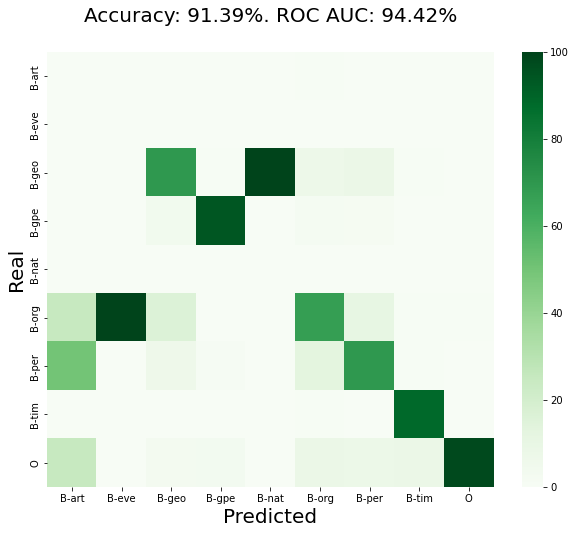

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(results2, cmap='Greens', annot=False)
plt.xlabel('Predicted',fontsize=20)
plt.ylabel('Real',fontsize=20)
plt.title(f"Accuracy: {accuracy}%. ROC AUC: {roc_auc}%",fontsize=20,pad=30)
plt.show()